# **Семинар 3 - Рекуррентные нейронные сети**

## 1. Понимание рекуррентных архитектур

### 1.1 Recurrent Neural Network (RNN)

<img src=https://avatars.mds.yandex.net/get-zen_doc/3431006/pub_5ed693e6eef56d43885b5c36_5ed693feaea73f25554811d9/orig alt="RNN" width="50%"/>

$$ H^{(t)} = \tanh \Big( W^{h x} \cdot X^{(t)} + W^{h h} \cdot H^{(t-1)} + b_{h} \Big) $$
$$ Y^{(t)} = W^{y h} \cdot H^{(t)} + b_{y} $$

### 1.2 Long-Short Term Memory (LSTM)

<img src=https://cdn-images-1.medium.com/max/950/1*76Mikf2yo1Q3U76hp17v9Q.gif alt="LSTM" width="70%"/>

$$ \text{input:} \quad i^{(t)} = \sigma \Big( W^{i x} \cdot X^{(t)} + W^{i h} \cdot H^{(t-1)} + b_{i} \Big) $$
$$ \text{output:} \quad o^{(t)} = \sigma \Big( W^{h x} \cdot X^{(t)} + W^{o h} \cdot H^{(t-1)} + b_{o} \Big) $$
$$ \text{forget:} \quad f^{(t)} = \sigma \Big( W^{h x} \cdot X^{(t)} + W^{f h} \cdot H^{(t-1)} + b_{f} \Big) $$
$$ \tilde{H}^{(t)} = \tanh \Big( W^{g x} \cdot X^{(t)} + W^{g h} \cdot H^{(t-1)} + b_{g} \Big) $$
$$ C^{(t)} = \tilde{H}^{(t)} \odot i^{(t)} + C^{(t-1)} \odot f^{(t)} $$
$$ H^{(t)} = \tanh \Big( C^{(t)} \Big) \odot o^{(t)} $$
$$ Y^{(t)} = W^{y h} \cdot H^{(t)} + b_{y} $$

### 1.3 Gated Recurrent Unit (GRU)

<img src=https://vbystricky.github.io/images/2021-05/gru.svg alt="LSTM" width="55%"/>

$$ \text{update:} \quad z^{(t)} = \sigma \Big( W^{z x} \cdot X^{(t)} + W^{z h} \cdot H^{(t-1)} + b_{i} \Big) $$
$$ \text{reset:} \quad r^{(t)} = \sigma \Big( W^{r x} \cdot X^{(t)} + W^{r h} \cdot H^{(t-1)} + b_{r} \Big) $$
$$ \tilde{H}^{(t)} = \tanh \Big(  W^{\tilde{h} x} \cdot X^{(t)} + W^{\tilde{h} h} \cdot \big( r^{(t)} \odot H^{(t-1)} \big) + b_{\tilde{h}} \Big) $$
$$ H^{(t)} = (1 - z^{(t)}) \odot H^{(t - 1)} + z^{(t)} \odot \tilde{H}^{(t)} $$
$$ Y^{(t)} = W^{y h} \cdot H^{(t)} + b_{y} $$

### 1.4 Как получить предсказание? Какие бывают задачи?

**Sequence to sequence (seq2seq):**

<img src=https://vbystricky.github.io/images/2021-05/rnn_seq_to_seq.svg alt="tags" width="55%"/>

К примеру, определение частей речи в предложении

<img src=https://vbystricky.github.io/images/2021-05/rnn_seq_to_seq_v2.svg alt="seq2seq" width="55%"/>

К примеру, автоматический перевод

**Sequence to one:**

<img src=https://vbystricky.github.io/images/2021-05/rnn_seq_to_one.svg alt="one class" width="55%"/>

К примеру, предсказание оценки, соответствующей данному ревью фильма

**One to sequence:**

<img src=https://vbystricky.github.io/images/2021-05/rnn_one_to_seq.svg alt="sequence" width="55%"/>

К примеру, составление текстового описания по чему-нибудь

## 2. Задача классификации текста

### 2.1 Скачиваем данные

In [48]:
#!g1.1
# For datasphere
# %pip install torchtext

# For google collab
!pip install torchtext

In [49]:
#!g1.1
from torchtext import datasets
from IPython.display import clear_output
import os
from datetime import datetime

download_dir = './datasets'

all_datasets = [
#     'AG_NEWS',
#     'DBpedia',
#     'YelpReviewPolarity',
#     'YelpReviewFull',
#     'YahooAnswers',
#     'AmazonReviewPolarity',
#     'AmazonReviewFull',
      'IMDB'
]


data = {'train': {}, 'test': {}}
download_time = dict()
for i, dataset_name in enumerate(all_datasets):
    clear_output(True)
    start_time = datetime.now() 
    
    print(f'{i+1}/{len(all_datasets)}: Downloading dataset {dataset_name}')
    
    download_exec = f'data[\'train\'][dataset_name] = datasets.{dataset_name}(root=\'{os.path.join(download_dir, dataset_name)}\', split=\'train\')'
    download_val_exec = f'data[\'test\'][dataset_name] = datasets.{dataset_name}(root=\'{os.path.join(download_dir, dataset_name)}\', split=\'test\')'
    
    # NEVER REPEAT THIS AT HOME
    exec(download_exec)
    exec(download_val_exec)
    download_time[dataset_name] = datetime.now() - start_time
    
    for split in ['train', 'test']:
        data[split][dataset_name] = [(l, t) for (l, t) in data[split][dataset_name]]
    

clear_output(True)
print('Download time:')
for k, v in download_time.items():
    print('{: <20} ~ {}'.format(k, v))

Download time:
IMDB                 ~ 0:00:33.373749


### 2.2 Посмотрим на данные

In [50]:
#!g1.1
from termcolor import colored

show_each = 5
num_classes = {}

for dataset_name in data['train']:
    num_classes[dataset_name] = len(set([label for (label, _) in data['train'][dataset_name]]))
    
    train_size = len(data['train'][dataset_name])
    test_size = len(data['test'][dataset_name])
    print(colored(dataset_name + f' ~ {train_size} train examples' +
                  f' and {test_size} test examples' +
                  f' with {num_classes[dataset_name]} classes:\n',
                  'red', attrs=['bold', 'underline']))
    
    for i in range(0, train_size, train_size // show_each):
        label, text = data['train'][dataset_name][i]
        print(f'  ' + colored(f'ind', attrs=['bold', 'underline']) +
              f' ~ {i}:\n  ' + colored(f'label', attrs=['bold', 'underline']) +
              f' ~ {label}\n  ' + colored(f'text', attrs=['bold', 'underline']) +
              f' ~ {text}\n')
    print('\n============\n')

IMDB ~ 25000 train examples and 25000 test examples with 2 classes:

  ind ~ 0:
  label ~ neg
  text ~ I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 year

### 2.3 Готовим данные

Очень много разных подходов:

- стоп-слова
- токенизация
- лемматизация
- стемминг
- обучаемые эмбеддинги
- лингвистические модели
- ...

In [51]:
#!g1.1
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
        
splits = ['train', 'test']

# Creating tokenizer for english text
tokenizer = get_tokenizer('basic_english')
max_size = [0] * (len(all_datasets) * len(splits))

# Building vocabs
def yield_tokens(it_list):
    global max_size
    for i, it in enumerate(tqdm(it_list)):
        for _, text in it:
            tokens = tokenizer(text)
            max_size[i] = max(max_size[i], len(tokens))
            yield tokens

def flat_list(list_):
    res = []
    for el in list_:
        res.extend(el)
    return res

vocab = {}
print('Building vocabs:')
vocab = build_vocab_from_iterator(
    yield_tokens(flat_list(
        [[data[split][dataset_name] for dataset_name in all_datasets] for split in splits]
    )),
    specials=["<unk>", "<pad>"]
)
vocab.set_default_index(vocab["<unk>"])

Building vocabs:


  0%|          | 0/2 [00:00<?, ?it/s]

In [52]:
#!g1.1
unk_id = vocab['<unk>']
pad_id = vocab['<pad>']
print(f'<unk> ~ {unk_id}\n<pad> ~ {pad_id}')

word = 'squirrel'
word_id = vocab[word]
print(f'{word} ~ {word_id}')

<unk> ~ 0
<pad> ~ 1
squirrel ~ 21691


In [53]:
#!g1.1
len(vocab)

147158

In [54]:
#!g1.1
text = 'Some random text, that I want to tokenize! <pad> <pad> <pad> and one unrecognizable w@rd'
print(f'tokenized:\n---- {tokenizer(text)}\n')
print(f'indexes from vocab:\n---- {vocab(tokenizer(text))}')

tokenized:
---- ['some', 'random', 'text', ',', 'that', 'i', 'want', 'to', 'tokenize', '!', '<pad>', '<pad>', '<pad>', 'and', 'one', 'unrecognizable', 'w@rd']

indexes from vocab:
---- [56, 1428, 3130, 4, 15, 13, 188, 8, 0, 36, 1, 1, 1, 5, 35, 12414, 0]


In [55]:
#!g1.1
import numpy as np

max_size = np.array(max_size).reshape(2, -1)
for i, dataset_name in enumerate(all_datasets):
    print(f'{dataset_name} ~ max_size: {max_size[:,i]}')

IMDB ~ max_size: [2752 2623]


In [56]:
#!g1.1
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
chosen_dataset = 'IMDB'
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

for i, dataset_name in enumerate(all_datasets):
    if dataset_name == chosen_dataset:
        max_ = max(max_size[:,i])
print(f'maximal text length ~ {max_}')

max_ = min(max_, 128)

maximal text length ~ 2752


In [57]:
#!g1.1
import torch

# Text and label preprocessing
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 0 if x == 'neg' else 1 

# Applying preprocessings to batch
def collate_batch_offsets(batch):
    label_list, text_list, offsets = [], [], [0]
    for (label, text) in batch:
        label_list.append(label_pipeline(label))
        processed_text = torch.tensor(text_pipeline(text),
                                      dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.cat(text_list)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    return label_list, text_list, offsets

# Applying preprocessings to batch
def collate_batch_padding(batch):
    label_list, text_list = [], []
    for (label, text) in batch:
        label_list.append(label_pipeline(label))
        processed_text = text_pipeline(text)
        if len(processed_text) < max_:
            processed_text = processed_text + [pad_id] * (max_ - len(processed_text))
        else:
            processed_text = processed_text[:max_]
        text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.tensor(text_list, dtype=torch.int64)
    return label_list, text_list

In [58]:
#!g1.1
# Making dataloaders
dataloaders_off = {split: {} for split in splits}
dataloaders_pad = {split: {} for split in splits}

print('Making dataloaders...')

batch_size = 64

for split in splits:
    dataloaders_off[split][chosen_dataset] = DataLoader(
        data[split][chosen_dataset],
        batch_size=batch_size,
        shuffle=(split=='train'),
        drop_last=(split=='train'),
        collate_fn=collate_batch_offsets
    )
    dataloaders_pad[split][chosen_dataset] = DataLoader(
        data[split][chosen_dataset],
        batch_size=batch_size,
        shuffle=(split=='train'),
        drop_last=(split=='train'),
        collate_fn=collate_batch_padding
    )

Making dataloaders...


In [59]:
#!g1.1
for l_, t_, o_ in dataloaders_off['train'][chosen_dataset]:
    print(f'labels ~ {l_.shape}\n{l_}\n')
    print(f'texts ~ {t_.shape}\n{t_}\n')
    print(f'offsets ~ {o_.shape}\n{o_}')
    break

labels ~ torch.Size([64])
tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1])

texts ~ torch.Size([15631])
tensor([31452,    10,     6,  ...,    34,   133,     3])

offsets ~ torch.Size([64])
tensor([    0,   147,   303,   459,   539,   889,  1048,  1255,  1449,  2001,
         2148,  2569,  2930,  3053,  3388,  3471,  3653,  3696,  4054,  4334,
         4928,  5216,  5489,  5644,  5768,  5875,  6156,  6301,  6431,  7344,
         7512,  7780,  7958,  8278,  8407,  9074,  9305,  9456,  9707,  9835,
        10017, 10284, 10374, 10639, 10791, 10889, 11140, 11360, 11587, 11762,
        12131, 12705, 12856, 12980, 13143, 13502, 13650, 13795, 14000, 14194,
        14575, 15077, 15419, 15599])


In [60]:
#!g1.1
for l_, t_ in dataloaders_pad['train'][chosen_dataset]:
    print(f'labels ~ {l_.shape}\n{l_}\n')
    print(f'texts ~ {t_.shape}\n{t_}\n')
    break

labels ~ torch.Size([64])
tensor([1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1])

texts ~ torch.Size([64, 128])
tensor([[  244,     2,    97,  ...,     3, 18549,   313],
        [   13,     9,   151,  ...,   960,    10,    61],
        [ 2411,  3660,     2,  ...,    27,    33,  4097],
        ...,
        [   79,    13,   241,  ...,   150,   559,   132],
        [   14,    71,    10,  ...,    79,    15,     2],
        [   51,     2,  1443,  ...,   107,     5,    13]])



## 3. Составляем модель и пайплайн обучения

### 3.1 Рекуррентная модель

In [61]:
#!g1.1
from torch import nn

class RecurrentModel(nn.Module):
    """
        Network with recurrent block
    """
    def __init__(self, vocab_size, input_size, hidden_size, output_size, rnn_type,
                 num_layers, bidirectional, dropout_p, reduce='last'):
        super(RecurrentModel, self).__init__()
        self.rnn_type = rnn_type
        D = 2 if bidirectional else 1
        self.reduce = reduce
        
        rnn_types = [nn.RNN, nn.LSTM, nn.GRU]
        if rnn_type not in rnn_types:
            raise ValueError(f'rnn_cell should be one of {rnn_types}')
        
        reduce_ways = ['last', 'max', 'mean', 'sum']
        assert reduce in reduce_ways, print(f'reduce must be one of {reduce_ways}')
        
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=input_size)
        
        self.rnn_layers = rnn_type(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout_p,
            batch_first=True
        )
        
        self.to_class = nn.Linear(hidden_size * D, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, texts):
        texts = self.embed(texts)
        
        if self.rnn_type == nn.LSTM:
            output, (hn, cn) = self.rnn_layers(texts)
        else:
            output, hn = self.rnn_layers(texts)
        
        if self.reduce == 'last':
            output = output[:, -1, :]
        elif self.reduce == 'mean':
            output = output.mean(1)
        elif self.reduce == 'max':
            output = output.max(1)
        elif self.reduce == 'sum':
            output = output.sum(1)
        
        return self.logsoftmax(self.to_class(output))

In [62]:
#!g1.1
hashing_trick_size = 5000

model_rnn = RecurrentModel(
    vocab_size = hashing_trick_size,
    input_size = 500,
    hidden_size = 100,
    output_size = num_classes[chosen_dataset],
    rnn_type = nn.RNN,
    num_layers = 3,
    bidirectional = True,
    dropout_p = 0.3,
    reduce = 'last'
)

print('Model:', model_rnn, sep='\n')

labels_batch, texts_batch = next(iter(dataloaders_pad['train'][chosen_dataset]))

print(f'\nInput shape: {texts_batch.shape}')
out = model_rnn(texts_batch % hashing_trick_size)
print(f'Output shape: {out.shape}')

print(f'\nChecking that returned probabilities (all sums must be close to 1)',
      np.sum(np.exp(out.detach().numpy()), axis=1), sep='\n')

Model:
RecurrentModel(
  (embed): Embedding(5000, 500)
  (rnn_layers): RNN(500, 100, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (to_class): Linear(in_features=200, out_features=2, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

Input shape: torch.Size([64, 128])
Output shape: torch.Size([64, 2])

Checking that returned probabilities (all sums must be close to 1)
[1.         1.         1.         1.         0.99999994 1.
 1.         1.         0.99999994 0.99999994 1.         1.
 1.         1.         1.         0.99999994 1.         1.
 1.         1.         0.9999999  1.         1.         0.9999999
 1.         1.         1.         1.         1.         1.
 1.0000001  1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.9999999
 1.         1.         1.         1.         1.         0.99999994
 1.         1.         1.         1.         0.99999994 1.
 1.         1.         1.         1.         1.         1.

In [63]:
#!g1.1
# Counting how many parameters does our model have
def model_num_params(model):
    sum_params = 0
    for param in model.named_parameters():
        num_params = np.prod(param[1].shape)
        print('{: <19} ~  {: <7} params'.format(param[0], num_params))
        sum_params += num_params
    print(f'\nIn total: {sum_params} params')
    return sum_params

sum_params = model_num_params(model_rnn)

embed.weight        ~  2500000 params
rnn_layers.weight_ih_l0 ~  50000   params
rnn_layers.weight_hh_l0 ~  10000   params
rnn_layers.bias_ih_l0 ~  100     params
rnn_layers.bias_hh_l0 ~  100     params
rnn_layers.weight_ih_l0_reverse ~  50000   params
rnn_layers.weight_hh_l0_reverse ~  10000   params
rnn_layers.bias_ih_l0_reverse ~  100     params
rnn_layers.bias_hh_l0_reverse ~  100     params
rnn_layers.weight_ih_l1 ~  20000   params
rnn_layers.weight_hh_l1 ~  10000   params
rnn_layers.bias_ih_l1 ~  100     params
rnn_layers.bias_hh_l1 ~  100     params
rnn_layers.weight_ih_l1_reverse ~  20000   params
rnn_layers.weight_hh_l1_reverse ~  10000   params
rnn_layers.bias_ih_l1_reverse ~  100     params
rnn_layers.bias_hh_l1_reverse ~  100     params
rnn_layers.weight_ih_l2 ~  20000   params
rnn_layers.weight_hh_l2 ~  10000   params
rnn_layers.bias_ih_l2 ~  100     params
rnn_layers.bias_hh_l2 ~  100     params
rnn_layers.weight_ih_l2_reverse ~  20000   params
rnn_layers.weight_hh_l2_reve

### 3.2 Оптимизатор

In [64]:
#!g1.1
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def create_model_and_optimizer(model_class, model_params, lr=1e-3, beta1=0.9, beta2=0.999, device=device):
    model = model_class(**model_params)
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr, [beta1, beta2])
    return model, optimizer

In [65]:
#!g1.1
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
Tesla T4


In [66]:
#!g1.1
model_params = {
    'vocab_size': hashing_trick_size,
    'input_size': 256,
    'hidden_size': 128,
    'output_size': num_classes[chosen_dataset],
    'rnn_type': nn.RNN,
    'num_layers': 3,
    'bidirectional': True,
    'dropout_p': 0.3,
    'reduce': 'last'
}

model, optimizer = create_model_and_optimizer(
    model_class = RecurrentModel, 
    model_params = model_params,
    lr = 1e-3,
)

### 3.3 Обучение/валидация одной эпохи

In [67]:
#!g1.1
import torch.nn.functional as F
from tqdm.notebook import tqdm

criterion = nn.NLLLoss()

def train(model, optimizer, loader, criterion):
    model.train()
    losses_tr = []
    for labels, texts in tqdm(loader):
        labels = labels.to(device)
        texts = texts.to(device)
        
        optimizer.zero_grad()
        out = model(texts % hashing_trick_size)
        loss = criterion(out, labels)
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item()) 
    
    return model, optimizer, np.mean(losses_tr)

def val(model, loader, criterion):
    model.eval()
    losses_val = []
    with torch.no_grad():
        for labels, texts in tqdm(loader):
            labels = labels.to(device)
            texts = texts.to(device)
            out = model(texts % hashing_trick_size)
            loss = criterion(out, labels)

            losses_val.append(loss.item())
    
    return np.mean(losses_val)

### 3.4 Цикл обучения

In [68]:
#!g1.1
from IPython.display import clear_output
from tqdm.notebook import trange
import matplotlib.pyplot as plt
%matplotlib inline


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def learning_loop(model, optimizer, train_loader, val_loader, criterion, scheduler=None, min_lr=None,
                  epochs=10, val_every=1, draw_every=1, separate_show=False):
    losses = {'train': [], 'val': []}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss = val(model, val_loader, criterion)
            losses['val'].append(loss)
            if scheduler:
                scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(1, 2 if separate_show else 1, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            if separate_show:
                plt.subplot(121)
                plt.title('loss on train')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.legend()

            if separate_show:
                plt.subplot(122)
                plt.title('loss on validation')
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses

### 3.5 Обучаем модели

In [69]:
#!g1.1
model_params = dict()
model = dict()
optimizer = dict()
scheduler = dict()
criterion = dict()
losses = dict()

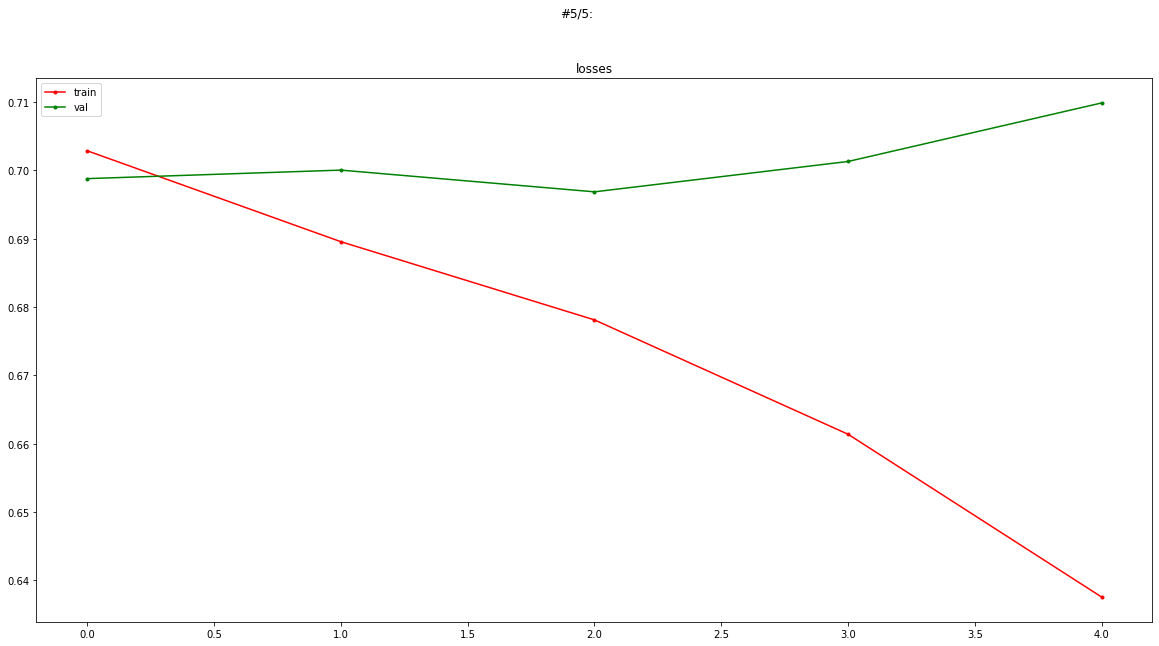

CPU times: user 1min 12s, sys: 792 ms, total: 1min 12s
Wall time: 1min 19s


In [70]:
#!g1.1
%%time

model_type = 'bi-rnn'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params[model_type] = {
    'vocab_size': hashing_trick_size,
    'input_size': 256,
    'hidden_size': 128,
    'output_size': num_classes[chosen_dataset],
    'rnn_type': nn.RNN,
    'num_layers': 1,
    'bidirectional': True,
    'dropout_p': 0.3,
    'reduce': 'last'
}

model[model_type], optimizer[model_type] = create_model_and_optimizer(
    model_class = RecurrentModel, 
    model_params = model_params[model_type],
    lr = 1e-3,
    device = device,
)

epochs = 5

scheduler[model_type] = torch.optim.lr_scheduler.LinearLR(
    optimizer[model_type],
    start_factor = 0.5,
    end_factor = 1.0,
    total_iters = 2
)

criterion[model_type] = nn.NLLLoss()

model[model_type], optimizer[model_type], losses[model_type] = learning_loop(
    model = model[model_type],
    optimizer = optimizer[model_type],
    train_loader = dataloaders_pad['train'][chosen_dataset],
    val_loader = dataloaders_pad['test'][chosen_dataset],
    criterion = criterion[model_type],
    scheduler = scheduler[model_type],
    epochs = epochs,
    min_lr = 2e-6
)

In [71]:
#!g1.1
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score


def eval(model, loader, metric_names):
    model.eval()
    all_labels = []
    all_probas = []
    all_predicts = []
    with torch.no_grad():
        for labels, texts in tqdm(loader):
            labels = labels.to(device)
            texts = texts.to(device)
            out = model(texts % hashing_trick_size)

            all_predicts.extend(out.argmax(1).cpu().detach().numpy())
            all_probas.extend(out.exp()[:, 1].cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

    metrics = {name: None for name in metric_names}
    if 'accuracy' in metrics:
        metrics['accuracy'] = accuracy_score(all_labels, all_predicts)
    if 'roc_auc' in metrics:
        metrics['roc_auc'] = roc_auc_score(all_labels, all_probas)
    if 'f1' in metrics:
        metrics['f1'] = f1_score(all_labels, all_predicts)
    return metrics

In [72]:
#!g1.1
eval(model[model_type], dataloaders_pad['test'][chosen_dataset], ['accuracy', 'roc_auc', 'f1'])

  0%|          | 0/391 [00:00<?, ?it/s]

{'accuracy': 0.57452, 'f1': 0.580477223427332, 'roc_auc': 0.5958423904}

**Задание (3 балла).** Попробуйте взять другой датасет из torchtext (в начале ноутбука есть список доступных датасетов) и завести на нем обучение рекуррентной сети. Предлагается провести небольшое исследование и перебрать **хотя бы два** из предложенных параметров

- тип рекуррентной сети (RNN, LSTM, GRU) и сравнить качество моделей и скорость обучения
- размеры сети (например размеры эмбеддинга и скрытого состояния, число слоев/направлений в сети, способ reduce'а для вектора, подаваемого в полносвязный слой, etc.)
- способ обрезания текстов при подаче в сеть (оставлять только начальные токены, только конечные, с обеих сторон, etc.)
- максимальную длину текста на входе сети, тут можно сравнить время и качество обучения для входов разной длины
- размер пространства эмбеддингов (hashing trick)

Учить каждую сеть долго не обязательно, но пусть это будет ~5 эпох, чтобы можно было наблюдать убывающий лосс. Строгих критериев к итоговому качеству моделей нет, но оно должно отличаться от "рандома". Ниже опишите, что вы исследовали, и какие можно сделать выводы на основе получившихся результатов.


**Эксперименты:** (Тут можно коротко описать исследования, построить таблицу или график с результатами)

*Прошу прощения за такое большое количество кода :(*

#### *1. Сравним качество и скорость обучения в зависимости от типа сети.*

In [73]:
import time

train_time_1 = {}

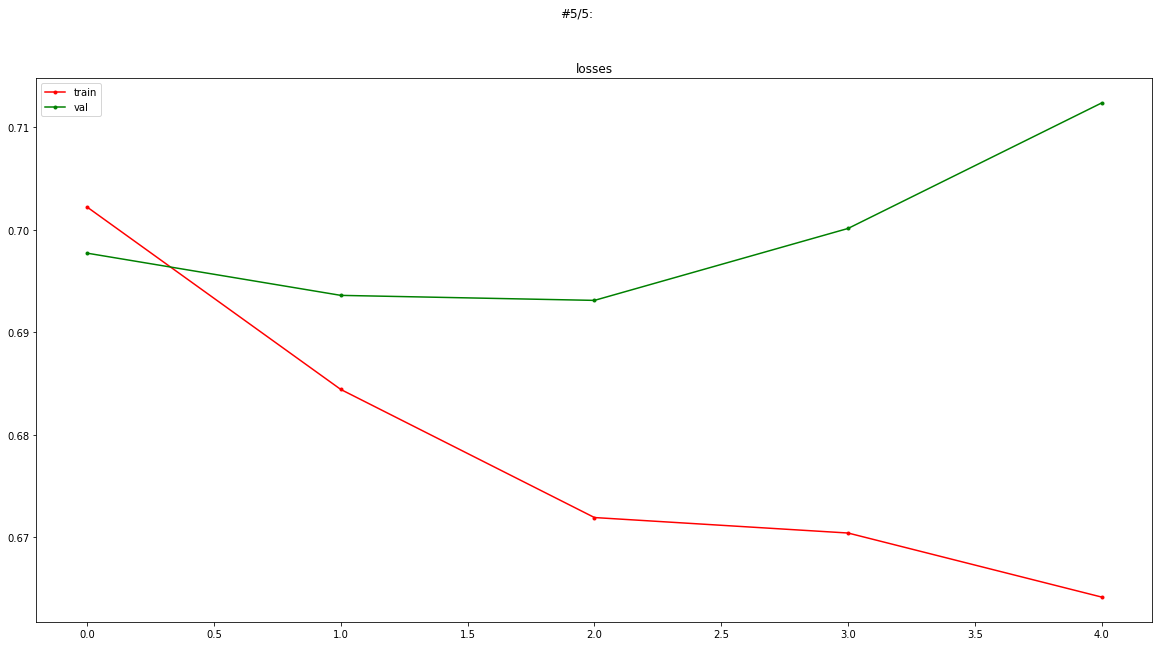

CPU times: user 59.7 s, sys: 653 ms, total: 1min
Wall time: 1min 2s


In [74]:
%%time

model_type = 'rnn'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params[model_type] = {
    'vocab_size': hashing_trick_size,
    'input_size': 256,
    'hidden_size': 128,
    'output_size': num_classes[chosen_dataset],
    'rnn_type': nn.RNN,
    'num_layers': 1,
    'bidirectional': False,
    'dropout_p': 0.3,
    'reduce': 'last'
}

model[model_type], optimizer[model_type] = create_model_and_optimizer(
    model_class = RecurrentModel, 
    model_params = model_params[model_type],
    lr = 1e-3,
    device = device,
)

epochs = 5

scheduler[model_type] = torch.optim.lr_scheduler.LinearLR(
    optimizer[model_type],
    start_factor = 0.5,
    end_factor = 1.0,
    total_iters = 2
)

criterion[model_type] = nn.NLLLoss()

start_time = time.time()

model[model_type], optimizer[model_type], losses[model_type] = learning_loop(
    model = model[model_type],
    optimizer = optimizer[model_type],
    train_loader = dataloaders_pad['train'][chosen_dataset],
    val_loader = dataloaders_pad['test'][chosen_dataset],
    criterion = criterion[model_type],
    scheduler = scheduler[model_type],
    epochs = epochs,
    min_lr = 2e-6
)

end_time = time.time()
train_time_1[model_type] = end_time - start_time

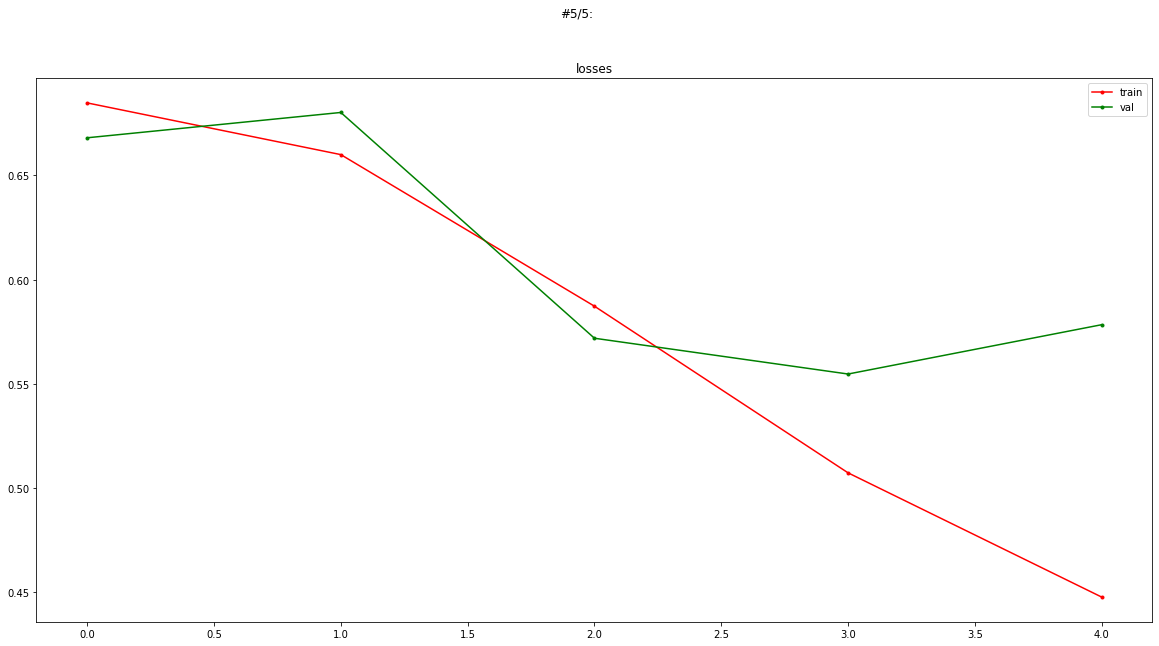

CPU times: user 1min 2s, sys: 677 ms, total: 1min 3s
Wall time: 1min 4s


In [75]:
%%time

model_type = 'lstm'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params[model_type] = {
    'vocab_size': hashing_trick_size,
    'input_size': 256,
    'hidden_size': 128,
    'output_size': num_classes[chosen_dataset],
    'rnn_type': nn.LSTM,
    'num_layers': 1,
    'bidirectional': False,
    'dropout_p': 0.3,
    'reduce': 'last'
}

model[model_type], optimizer[model_type] = create_model_and_optimizer(
    model_class = RecurrentModel, 
    model_params = model_params[model_type],
    lr = 1e-3,
    device = device,
)

epochs = 5

scheduler[model_type] = torch.optim.lr_scheduler.LinearLR(
    optimizer[model_type],
    start_factor = 0.5,
    end_factor = 1.0,
    total_iters = 2
)

criterion[model_type] = nn.NLLLoss()

start_time = time.time()

model[model_type], optimizer[model_type], losses[model_type] = learning_loop(
    model = model[model_type],
    optimizer = optimizer[model_type],
    train_loader = dataloaders_pad['train'][chosen_dataset],
    val_loader = dataloaders_pad['test'][chosen_dataset],
    criterion = criterion[model_type],
    scheduler = scheduler[model_type],
    epochs = epochs,
    min_lr = 2e-6
)

end_time = time.time()
train_time_1[model_type] = end_time - start_time

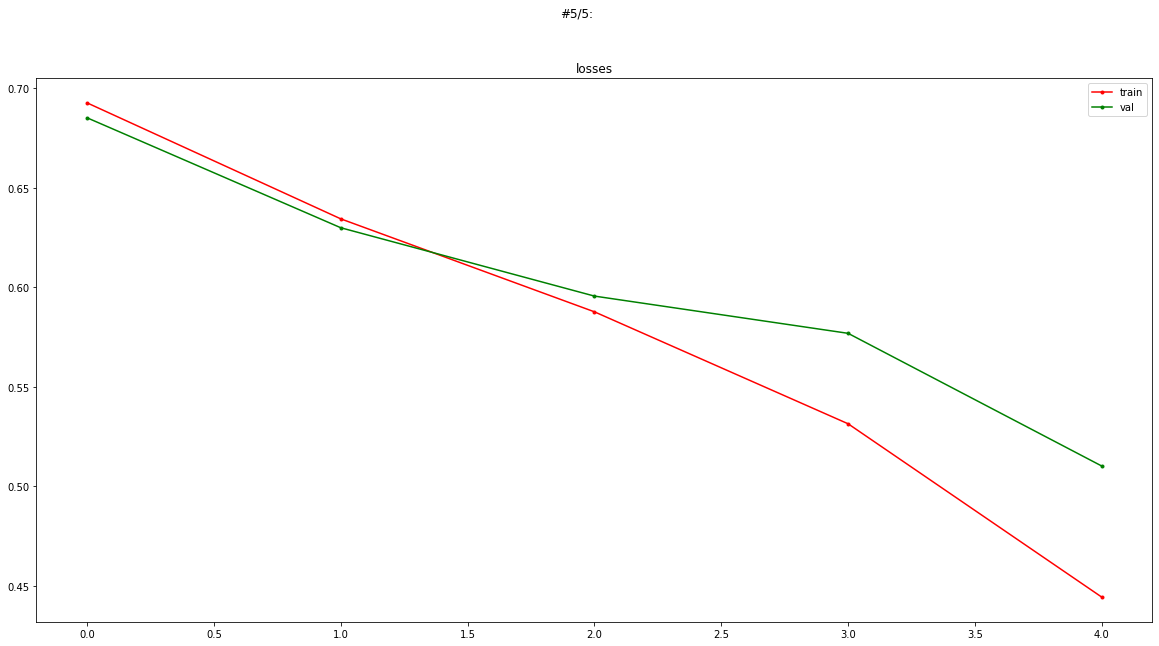

CPU times: user 1min 3s, sys: 672 ms, total: 1min 4s
Wall time: 1min 5s


In [76]:
%%time

model_type = 'gru'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params[model_type] = {
    'vocab_size': hashing_trick_size,
    'input_size': 256,
    'hidden_size': 128,
    'output_size': num_classes[chosen_dataset],
    'rnn_type': nn.GRU,
    'num_layers': 1,
    'bidirectional': False,
    'dropout_p': 0.3,
    'reduce': 'last'
}

model[model_type], optimizer[model_type] = create_model_and_optimizer(
    model_class = RecurrentModel, 
    model_params = model_params[model_type],
    lr = 1e-3,
    device = device,
)

epochs = 5

scheduler[model_type] = torch.optim.lr_scheduler.LinearLR(
    optimizer[model_type],
    start_factor = 0.5,
    end_factor = 1.0,
    total_iters = 2
)

criterion[model_type] = nn.NLLLoss()

start_time = time.time()

model[model_type], optimizer[model_type], losses[model_type] = learning_loop(
    model = model[model_type],
    optimizer = optimizer[model_type],
    train_loader = dataloaders_pad['train'][chosen_dataset],
    val_loader = dataloaders_pad['test'][chosen_dataset],
    criterion = criterion[model_type],
    scheduler = scheduler[model_type],
    epochs = epochs,
    min_lr = 2e-6
)

end_time = time.time()
train_time_1[model_type] = end_time - start_time

In [77]:
results_1 = (
    eval(model['rnn'], dataloaders_pad['test'][chosen_dataset], ['accuracy', 'roc_auc', 'f1']),
    eval(model['lstm'], dataloaders_pad['test'][chosen_dataset], ['accuracy', 'roc_auc', 'f1']),
    eval(model['gru'], dataloaders_pad['test'][chosen_dataset], ['accuracy', 'roc_auc', 'f1']),
)

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

#### *Результат*

In [78]:
import pandas as pd

pd.options.display.float_format = '{:.2f}'.format

results_1_df = pd.DataFrame(results_1, index=['rnn', 'lstm', 'gru'])
results_1_df['train_time'] = pd.Series(train_time_1)
results_1_df

,accuracy,roc_auc,f1,train_time
rnn,0.52,0.52,0.53,62.98
lstm,0.70,0.77,0.69,64.26
gru,0.76,0.83,0.76,65.84


*Здесь и дальше обучение за 5 эпох, время в секундах.*

*Можно сделать вывод, что RNN обучается быстрее, но хуже по точности, что, в принципе, обычно так и есть; GRU обучается немного быстрее, чем LSTM, и в этом конкретном случае обучилась точнее, но это вроде не всегда так.*

#### *2. Сравним качество и скорость обучения в зависимости от размера сети.*

In [79]:
train_time_2 = {}

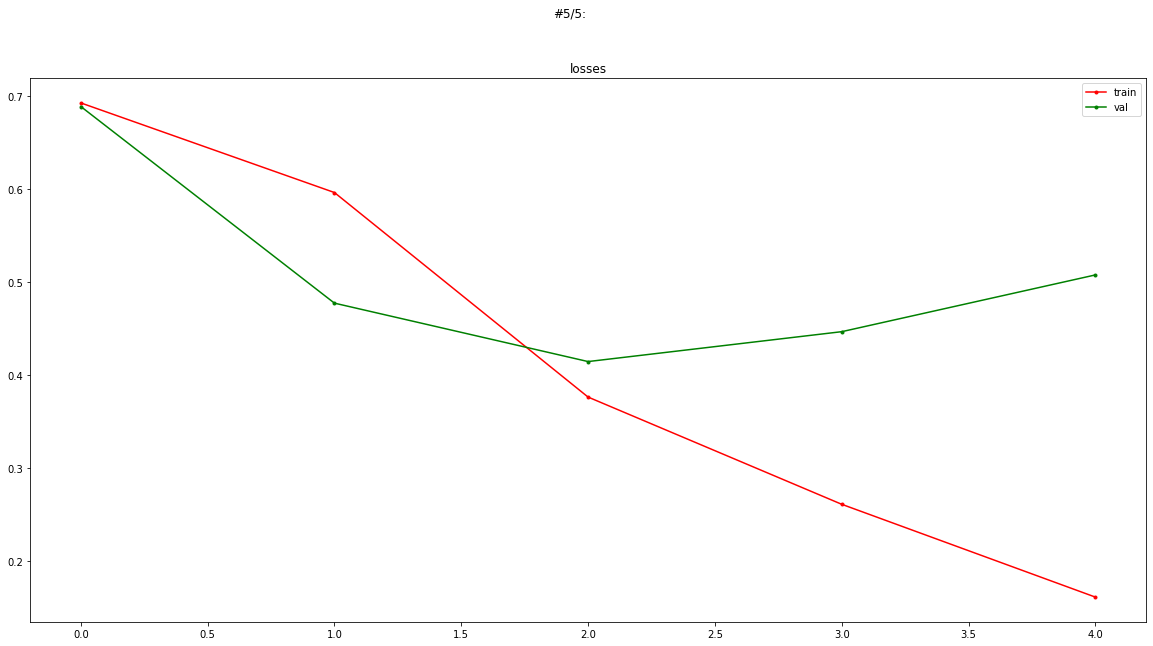

CPU times: user 1min 12s, sys: 699 ms, total: 1min 12s
Wall time: 1min 13s


In [80]:
%%time

model_type = 'gru_512_256'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params[model_type] = {
    'vocab_size': hashing_trick_size,
    'input_size': 512,
    'hidden_size': 256,
    'output_size': num_classes[chosen_dataset],
    'rnn_type': nn.GRU,
    'num_layers': 1,
    'bidirectional': False,
    'dropout_p': 0.3,
    'reduce': 'last'
}

model[model_type], optimizer[model_type] = create_model_and_optimizer(
    model_class = RecurrentModel, 
    model_params = model_params[model_type],
    lr = 1e-3,
    device = device,
)

epochs = 5

scheduler[model_type] = torch.optim.lr_scheduler.LinearLR(
    optimizer[model_type],
    start_factor = 0.5,
    end_factor = 1.0,
    total_iters = 2
)

criterion[model_type] = nn.NLLLoss()

start_time = time.time()

model[model_type], optimizer[model_type], losses[model_type] = learning_loop(
    model = model[model_type],
    optimizer = optimizer[model_type],
    train_loader = dataloaders_pad['train'][chosen_dataset],
    val_loader = dataloaders_pad['test'][chosen_dataset],
    criterion = criterion[model_type],
    scheduler = scheduler[model_type],
    epochs = epochs,
    min_lr = 2e-6
)

end_time = time.time()
train_time_2[model_type] = end_time - start_time

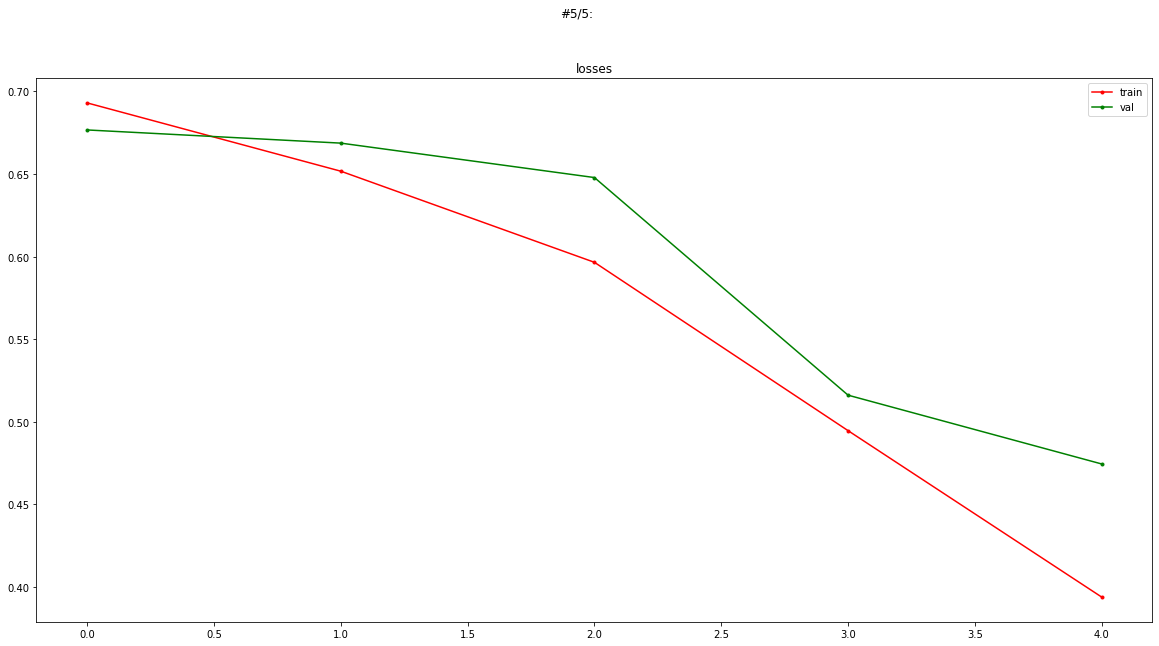

CPU times: user 1min 2s, sys: 674 ms, total: 1min 2s
Wall time: 1min 3s


In [81]:
%%time

model_type = 'gru_256_128'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params[model_type] = {
    'vocab_size': hashing_trick_size,
    'input_size': 256,
    'hidden_size': 128,
    'output_size': num_classes[chosen_dataset],
    'rnn_type': nn.GRU,
    'num_layers': 1,
    'bidirectional': False,
    'dropout_p': 0.3,
    'reduce': 'last'
}

model[model_type], optimizer[model_type] = create_model_and_optimizer(
    model_class = RecurrentModel, 
    model_params = model_params[model_type],
    lr = 1e-3,
    device = device,
)

epochs = 5

scheduler[model_type] = torch.optim.lr_scheduler.LinearLR(
    optimizer[model_type],
    start_factor = 0.5,
    end_factor = 1.0,
    total_iters = 2
)

criterion[model_type] = nn.NLLLoss()

start_time = time.time()

model[model_type], optimizer[model_type], losses[model_type] = learning_loop(
    model = model[model_type],
    optimizer = optimizer[model_type],
    train_loader = dataloaders_pad['train'][chosen_dataset],
    val_loader = dataloaders_pad['test'][chosen_dataset],
    criterion = criterion[model_type],
    scheduler = scheduler[model_type],
    epochs = epochs,
    min_lr = 2e-6
)

end_time = time.time()
train_time_2[model_type] = end_time - start_time

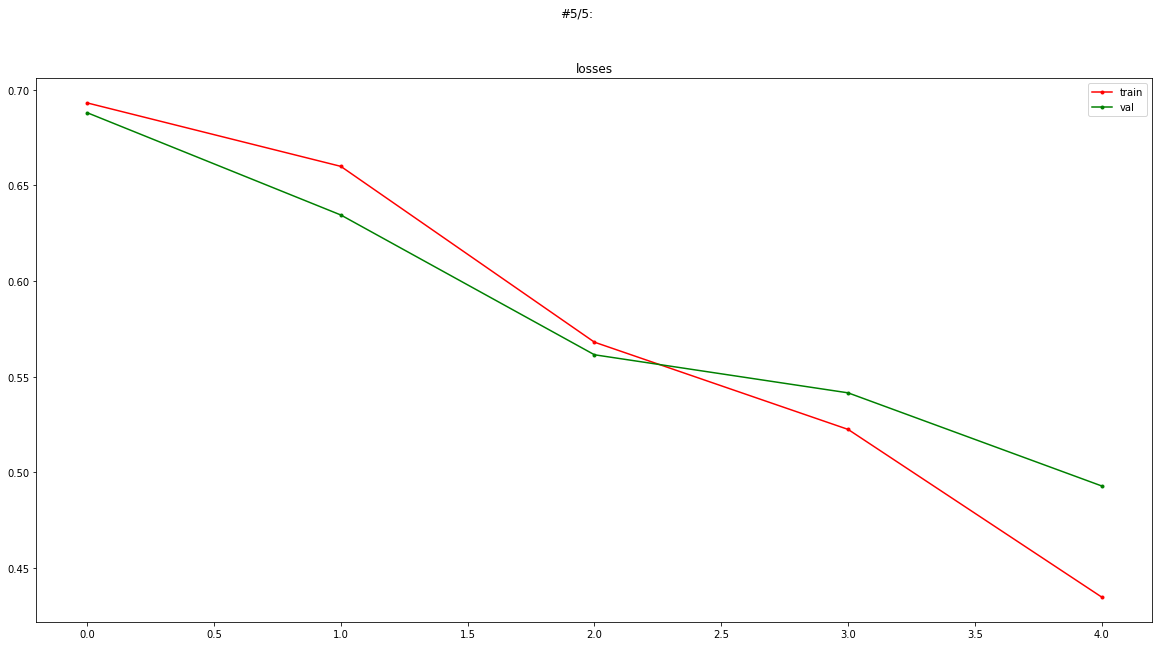

CPU times: user 1min, sys: 698 ms, total: 1min 1s
Wall time: 1min 1s


In [82]:
%%time

model_type = 'gru_192_96'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params[model_type] = {
    'vocab_size': hashing_trick_size,
    'input_size': 192,
    'hidden_size': 96,
    'output_size': num_classes[chosen_dataset],
    'rnn_type': nn.GRU,
    'num_layers': 1,
    'bidirectional': False,
    'dropout_p': 0.3,
    'reduce': 'last'
}

model[model_type], optimizer[model_type] = create_model_and_optimizer(
    model_class = RecurrentModel, 
    model_params = model_params[model_type],
    lr = 1e-3,
    device = device,
)

epochs = 5

scheduler[model_type] = torch.optim.lr_scheduler.LinearLR(
    optimizer[model_type],
    start_factor = 0.5,
    end_factor = 1.0,
    total_iters = 2
)

criterion[model_type] = nn.NLLLoss()

start_time = time.time()

model[model_type], optimizer[model_type], losses[model_type] = learning_loop(
    model = model[model_type],
    optimizer = optimizer[model_type],
    train_loader = dataloaders_pad['train'][chosen_dataset],
    val_loader = dataloaders_pad['test'][chosen_dataset],
    criterion = criterion[model_type],
    scheduler = scheduler[model_type],
    epochs = epochs,
    min_lr = 2e-6
)

end_time = time.time()
train_time_2[model_type] = end_time - start_time

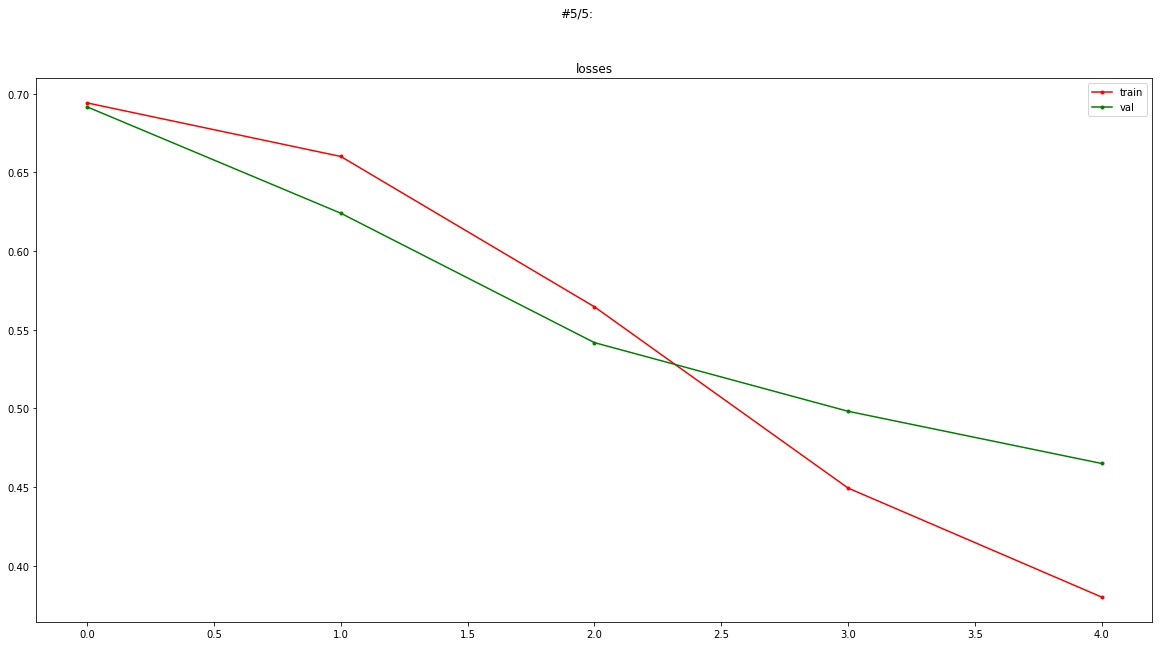

CPU times: user 60 s, sys: 645 ms, total: 1min
Wall time: 1min 1s


In [83]:
%%time

model_type = 'gru_128_64'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params[model_type] = {
    'vocab_size': hashing_trick_size,
    'input_size': 128,
    'hidden_size': 64,
    'output_size': num_classes[chosen_dataset],
    'rnn_type': nn.GRU,
    'num_layers': 1,
    'bidirectional': False,
    'dropout_p': 0.3,
    'reduce': 'last'
}

model[model_type], optimizer[model_type] = create_model_and_optimizer(
    model_class = RecurrentModel, 
    model_params = model_params[model_type],
    lr = 1e-3,
    device = device,
)

epochs = 5

scheduler[model_type] = torch.optim.lr_scheduler.LinearLR(
    optimizer[model_type],
    start_factor = 0.5,
    end_factor = 1.0,
    total_iters = 2
)

criterion[model_type] = nn.NLLLoss()

start_time = time.time()

model[model_type], optimizer[model_type], losses[model_type] = learning_loop(
    model = model[model_type],
    optimizer = optimizer[model_type],
    train_loader = dataloaders_pad['train'][chosen_dataset],
    val_loader = dataloaders_pad['test'][chosen_dataset],
    criterion = criterion[model_type],
    scheduler = scheduler[model_type],
    epochs = epochs,
    min_lr = 2e-6
)

end_time = time.time()
train_time_2[model_type] = end_time - start_time

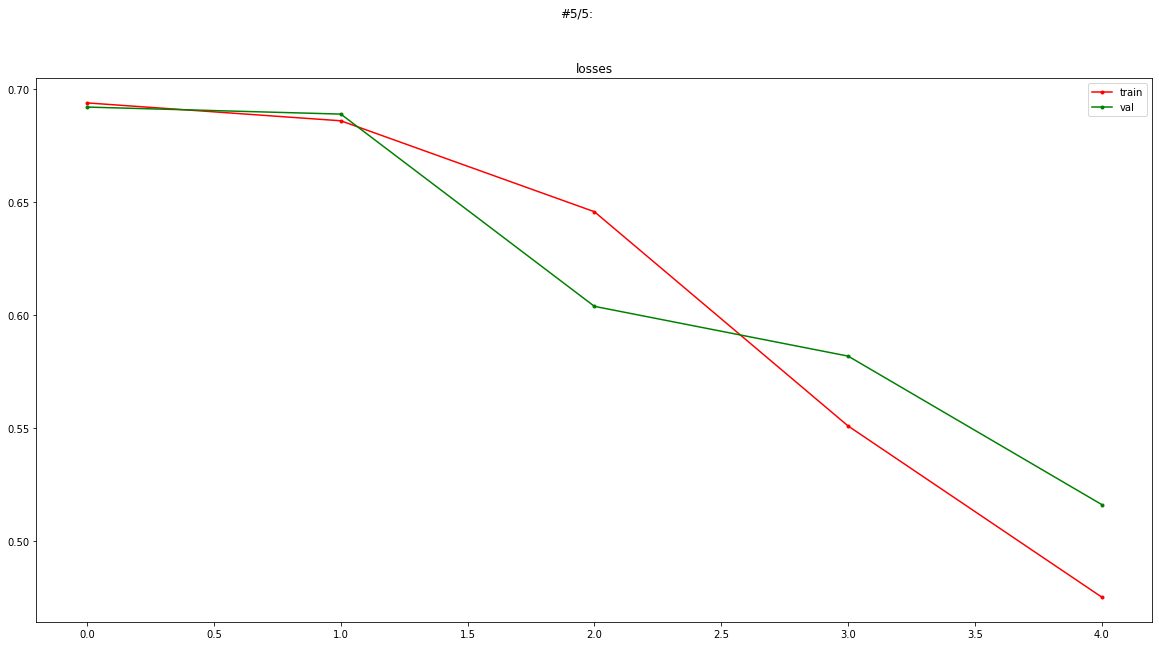

CPU times: user 1min, sys: 639 ms, total: 1min 1s
Wall time: 1min 5s


In [84]:
%%time

model_type = 'gru_64_32'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params[model_type] = {
    'vocab_size': hashing_trick_size,
    'input_size': 64,
    'hidden_size': 32,
    'output_size': num_classes[chosen_dataset],
    'rnn_type': nn.GRU,
    'num_layers': 1,
    'bidirectional': False,
    'dropout_p': 0.3,
    'reduce': 'last'
}

model[model_type], optimizer[model_type] = create_model_and_optimizer(
    model_class = RecurrentModel, 
    model_params = model_params[model_type],
    lr = 1e-3,
    device = device,
)

epochs = 5

scheduler[model_type] = torch.optim.lr_scheduler.LinearLR(
    optimizer[model_type],
    start_factor = 0.5,
    end_factor = 1.0,
    total_iters = 2
)

criterion[model_type] = nn.NLLLoss()

start_time = time.time()

model[model_type], optimizer[model_type], losses[model_type] = learning_loop(
    model = model[model_type],
    optimizer = optimizer[model_type],
    train_loader = dataloaders_pad['train'][chosen_dataset],
    val_loader = dataloaders_pad['test'][chosen_dataset],
    criterion = criterion[model_type],
    scheduler = scheduler[model_type],
    epochs = epochs,
    min_lr = 2e-6
)

end_time = time.time()
train_time_2[model_type] = end_time - start_time

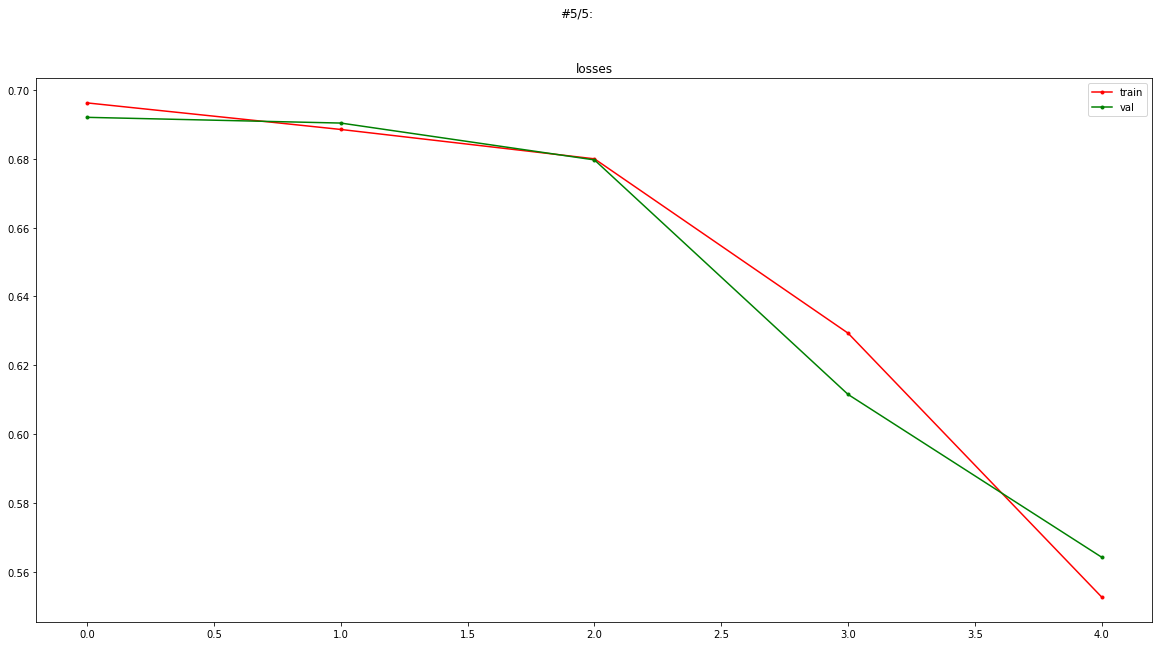

CPU times: user 57.8 s, sys: 640 ms, total: 58.5 s
Wall time: 59.1 s


In [85]:
%%time

model_type = 'gru_32_16'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params[model_type] = {
    'vocab_size': hashing_trick_size,
    'input_size': 32,
    'hidden_size': 16,
    'output_size': num_classes[chosen_dataset],
    'rnn_type': nn.GRU,
    'num_layers': 1,
    'bidirectional': False,
    'dropout_p': 0.3,
    'reduce': 'last'
}

model[model_type], optimizer[model_type] = create_model_and_optimizer(
    model_class = RecurrentModel, 
    model_params = model_params[model_type],
    lr = 1e-3,
    device = device,
)

epochs = 5

scheduler[model_type] = torch.optim.lr_scheduler.LinearLR(
    optimizer[model_type],
    start_factor = 0.5,
    end_factor = 1.0,
    total_iters = 2
)

criterion[model_type] = nn.NLLLoss()

start_time = time.time()

model[model_type], optimizer[model_type], losses[model_type] = learning_loop(
    model = model[model_type],
    optimizer = optimizer[model_type],
    train_loader = dataloaders_pad['train'][chosen_dataset],
    val_loader = dataloaders_pad['test'][chosen_dataset],
    criterion = criterion[model_type],
    scheduler = scheduler[model_type],
    epochs = epochs,
    min_lr = 2e-6
)

end_time = time.time()
train_time_2[model_type] = end_time - start_time

In [86]:
results_2 = (
    eval(model['gru_512_256'], dataloaders_pad['test'][chosen_dataset], ['accuracy', 'roc_auc', 'f1']),
    eval(model['gru_256_128'], dataloaders_pad['test'][chosen_dataset], ['accuracy', 'roc_auc', 'f1']),
    eval(model['gru_192_96'], dataloaders_pad['test'][chosen_dataset], ['accuracy', 'roc_auc', 'f1']),
    eval(model['gru_128_64'], dataloaders_pad['test'][chosen_dataset], ['accuracy', 'roc_auc', 'f1']),
    eval(model['gru_64_32'], dataloaders_pad['test'][chosen_dataset], ['accuracy', 'roc_auc', 'f1']),
    eval(model['gru_32_16'], dataloaders_pad['test'][chosen_dataset], ['accuracy', 'roc_auc', 'f1']),
)

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

#### *Результат*

In [97]:
import pandas as pd

pd.options.display.float_format = '{:.2f}'.format

results_2_df = pd.DataFrame(results_2, index=['gru_512_256', 'gru_256_128', 'gru_192_96', 'gru_128_64', 'gru_64_32', 'gru_32_16'])
results_2_df['train_time'] = pd.Series(train_time_2)
results_2_df

,accuracy,roc_auc,f1,train_time
gru_512_256,0.81,0.89,0.80,73.85
gru_256_128,0.78,0.86,0.79,63.38
gru_192_96,0.78,0.85,0.79,61.95
gru_128_64,0.79,0.87,0.79,61.33
gru_64_32,0.76,0.83,0.78,60.28
gru_32_16,0.72,0.78,0.71,59.08


*В названии модели первое число -- размер входного слоя, второе -- размер скрытого.*

*Здесь можно сделать вывод о том, что чем больше параметров, тем выше качество и больше время обучения. Я ожидал, что время будет отличаться сильнее, получилось вот так.*

По графикам лоссов видно, что чем больше размер, тем раньше лосс на валидации улетает вверх, а точность на самых больших моделях не сильно выше, это связано с переобучением.